# Imports

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import *
from gensim.models import Word2Vec
from node2vec import Node2Vec
from scipy.stats import pearsonr

import networkx as nx

from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

# Functions

In [230]:
def overlap(list1,list2):
    list3 = list(zip(list1, list2))
    count = 0
    for pair in list3:
        if pair[0] == 1 and pair[1] == 1:
            count += 1
    return count

# Graph Creation with NetworkX

In [231]:
node = pd.read_csv('node_information.csv', header=None)
train = pd.read_csv('train.txt', header=None, names=['Source','Target','Edge'], delim_whitespace=True)
test = pd.read_csv('test.txt', header=None, names=['Source','Target'], delim_whitespace=True)

In [232]:
node.loc[:, node.columns != node.columns[0]] = node.loc[:, node.columns != node.columns[0]].astype(int)
node[0] = node[0].astype(str)
node.head()

,0,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
nodes = [i for i in node[0]]
nodes[:10]

['0', '4', '5', '6', '7', '9', '10', '11', '13', '17']

In [234]:
# Creates the oriented graph
diG=nx.DiGraph()

# add the list of all nodes
diG.add_nodes_from(nodes)

# adds the corresponding links between two nodes in trainset
for i in range(train.shape[0]):
    if train['Edge'][i] == 1:
        diG.add_edge(str(train['Source'][i]), str(train['Target'][i]))

# Checks the number of edges and creates the non-oriented graph G
G = nx.Graph(diG)
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))

The number of nodes: 3597
The number of edges: 5248


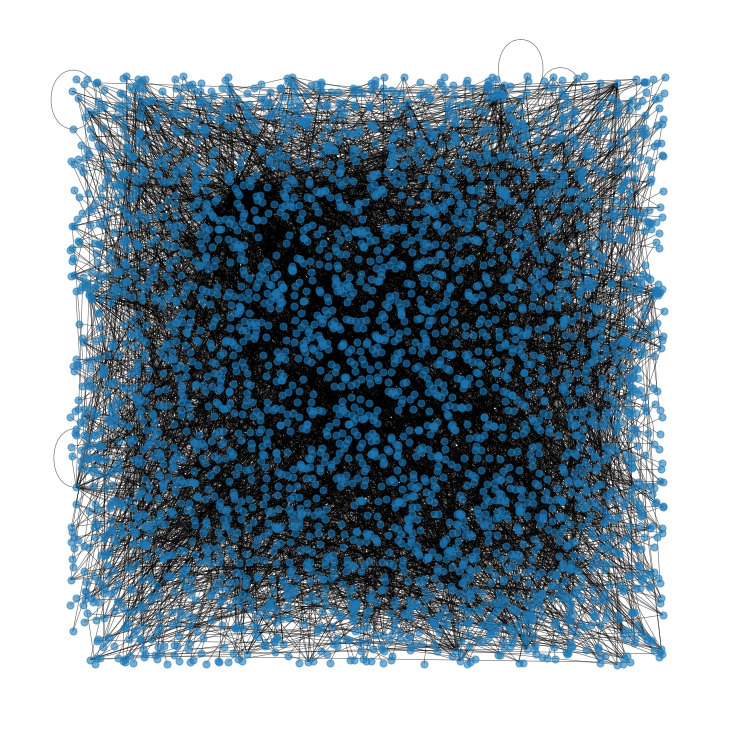

In [235]:
# Plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=19)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)

plt.show()

# Train_Val Samples Generating

In [236]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(G) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.seed(42)
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in edges:
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels


In [237]:
test_samples = [(str(test['Source'][i]),str(test['Target'][i])) for i in range(test.shape[0])]

In [238]:
# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, val_samples, val_labels = generate_samples(graph=G, train_set_ratio=0.7)

# Graph Embedding

In [239]:
def generate_random_walk(graph, root, L):
    """
    :param graph: networkx graph
    :param root: the node where the random walk starts
    :param L: the length of the walk
    :return walk: list of the nodes visited by the random walk
    """
    walk = [root]
    while len(walk) < L:
        current_node = walk[-1]
        candidates = list(nx.neighbors(graph, current_node))
        next = np.random.choice(candidates)
        walk.append(next) 

    return walk

In [240]:
def deep_walk(graph, N, L):
    '''
    :param graph: networkx graph
    :param N: the number of walks for each node
    :param L: the walk length
    :return walks: the list of walks
    '''
    walks = []
    np.random.seed(6) # fix random seed to obtain same random shuffling when repeating experiment
    nodes = list(G.nodes)

    for _ in range(N):
        np.random.shuffle(nodes) # shuffle the ordering of nodes, it helps speed up the convergence of stochastic gradient descent
        for node in nodes:
            # generate a random walk from the current visited node
            walk = generate_random_walk(graph, node, L)
            walks.append(walk)               
    return walks

# Node2Vec

In [241]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=32, walk_length=8, num_walks=500, workers=1, p=1, q=1)

# Embed nodes
model = node2vec.fit(window=5, min_count=1, batch_words=4)

EMBEDDING_MODEL_FILENAME = './embeddings.model'
model.save(EMBEDDING_MODEL_FILENAME)

Computing transition probabilities:   0%|          | 0/3597 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 500/500 [01:00<00:00,  8.21it/s]


# Edge_Prediction

In [242]:
def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Fill in the blanks

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Betweeness centrality measure
    betweeness_centrality = nx.betweenness_centrality(graph)

    # Page Rank Measure
    page_rank = nx.pagerank(graph)

    # Hub & Authority measure
    hub_score, authority_score = nx.hits(graph)

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Page Rank measure
        page_rank_source, page_rank_target = page_rank[source_node],page_rank[target_node]

        # Hub & Authority measure
        hub_source, hub_target = hub_score[source_node],hub_score[target_node]
        authority_source, authority_target = authority_score[source_node],authority_score[target_node]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality measure 
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        try:
            aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]
        except ZeroDivisionError:
            aai = 1

        # Jaccard
        jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]

        # Jaccard Similarity based on node info
        feature_source = node.loc[node[0] == source_node].values.tolist()[0][1:]
        feature_target = node.loc[node[0] == target_node].values.tolist()[0][1:]
        jaccard_similarity_nodeinfo = jaccard_score(feature_source, feature_target)

        # Common feature number
        overlap_num = overlap(feature_source,feature_target)
        
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        diff_bt, pref_attach, aai, jacard_coeff,
                                        page_rank_source, page_rank_target, 
                                        hub_source, hub_target, authority_source, authority_target,
                                        jaccard_similarity_nodeinfo, overlap_num])) 
        
    return feature_vector

In [243]:
train_features_partial = feature_extractor(G,train_samples)
val_features_partial = feature_extractor(G,val_samples)
test_features_partial = feature_extractor(G,test_samples)

c:\Anaconda\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
100%|██████████| 7348/7348 [00:15<00:00, 473.60it/s]
c:\Anaconda\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
100%|██████████| 3148/3148 [00:05<00:00, 528.62it/s]
c:\Anaconda\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
100%|██████████| 3498/3498 [00:06<00:00, 542.25it/s]


In [296]:
def edge_prediction(node2embedding, train_samples, val_samples, test_samples, train_labels, val_labels, feature_func=None, plot_roc=True):
    
    # --- Construct feature vectors for edges ---
    if feature_func is None:
        feature_func = lambda x,y: abs(x-y)
    
    # Fill in the blanks
    train_features_2 = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in train_samples]
    val_features_2 = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in val_samples]
    test_features_2 = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in test_samples]

    # adding feature_extractor
    train_features = np.concatenate((train_features_2, train_features_partial),axis=1)
    val_features = np.concatenate((val_features_2, val_features_partial),axis=1)
    test_features = np.concatenate((test_features_2, test_features_partial),axis=1)
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = MLPClassifier(solver='adam', activation="relu", hidden_layer_sizes=(128,32), tol=5e-5, max_iter=250, verbose=1)
    clf.fit(train_features, train_labels)

    val_preds = clf.predict_proba(val_features)[:, 1]
    val_predlabel = clf.predict(val_features)
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(val_labels, val_preds)
    roc_auc = auc(fpr, tpr)
    f1score = f1_score(val_labels, val_predlabel)

    if not plot_roc:
        return roc_auc
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return f1score, roc_auc, test_preds

Iteration 1, loss = 0.34441599
Iteration 2, loss = 0.18046142
Iteration 3, loss = 0.11215568
Iteration 4, loss = 0.06595941
Iteration 5, loss = 0.04094794
Iteration 6, loss = 0.03055395
Iteration 7, loss = 0.02798240
Iteration 8, loss = 0.02170421
Iteration 9, loss = 0.03111609
Iteration 10, loss = 0.01630279
Iteration 11, loss = 0.01099193
Iteration 12, loss = 0.00974909
Iteration 13, loss = 0.02874935
Iteration 14, loss = 0.01546443
Iteration 15, loss = 0.01154545
Iteration 16, loss = 0.00925169
Iteration 17, loss = 0.03052909
Iteration 18, loss = 0.01205474
Iteration 19, loss = 0.00861197
Iteration 20, loss = 0.00683962
Iteration 21, loss = 0.00558271
Iteration 22, loss = 0.01252180
Iteration 23, loss = 0.00882190
Iteration 24, loss = 0.01364568
Iteration 25, loss = 0.03410565
Iteration 26, loss = 0.01641785
Iteration 27, loss = 0.00661579
Iteration 28, loss = 0.01144576
Iteration 29, loss = 0.00745706
Iteration 30, loss = 0.00684171
Iteration 31, loss = 0.00514466
Iteration 32, los

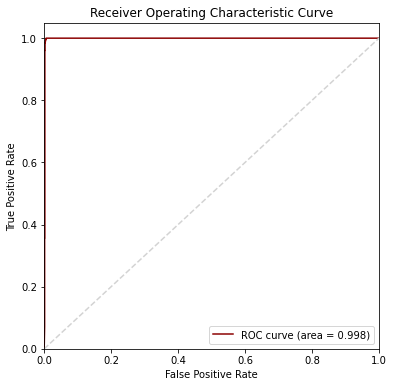

F1 Score on val set is 0.994, ROC_AUC Score on val set is 0.998


In [297]:
f1score, roc_auc,test_preds = edge_prediction(model.wv, train_samples, val_samples, test_samples, train_labels, val_labels, feature_func=None, plot_roc=True)
print("F1 Score on val set is {:.3f}, ROC_AUC Score on val set is {:.3f}".format(f1score, roc_auc))

# Submission

In [301]:
test_submission = []
for i in test_preds:
    if i < np.median(test_preds):
        test_submission.append(0)
    else:
        test_submission.append(1)

In [299]:
submission = pd.DataFrame()
submission['ID'] = list(range(len(test_submission)))
submission['Predicted'] = list(test_submission)
submission.to_csv('submission.csv', index = False)